In [1]:
import sys
sys.path.extend(['src'])

import imp
import numpy as np
from numpy.random import default_rng
from scipy import signal
from scipy.fft import rfft, rfftfreq
import pandas as pd
from tqdm import tqdm

from src import *

import matplotlib as mpl 
import matplotlib.pyplot as plt
from IPython.display import clear_output, HTML

## 0. Preparation

> Set plotting theme

In [2]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['xtick.labelsize'] = 8.5
plt.rcParams['ytick.labelsize'] = 8.5
plt.rcParams['xtick.major.pad'] = 2.1
plt.rcParams['ytick.major.pad'] = 2.1
plt.rcParams['xtick.minor.pad'] = 2.0
plt.rcParams['ytick.minor.pad'] = 2.0
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['axes.labelpad'] = 3
plt.rcParams['axes.titlepad'] = 4.5
plt.rcParams['grid.linewidth'] = .3
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.facecolor'] = '#fefefe'
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = .75
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['ytick.major.width'] = .75
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['figure.subplot.bottom'] = 0.165
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 120

> Define some functions

In [3]:
# plot spectrum of a signal
def plot_spectrum(figsize, data, fs, sensor_locs):
    fig, ax = plt.subplots(figsize=figsize)
    n = data.shape[0]
    Yf = rfft(data, axis=0) * 2 / n
    xf = rfftfreq(n, 1/fs)
    ax.semilogy(xf, np.abs(Yf), '.-', markersize=2)
    ax.legend([f'Node: {i}' for i in sensor_locs])
    ax.set_ylabel('Spectrum of node acc.')
    ax.set_xlabel('Frequency/Hz')
    plt.show()
    return fig, ax

## 1. FEM-simulated simply supported beam

> Free response excited by impulse force 

In [4]:
%matplotlib inline
fs = 500
T = 20
analysis_params = {
    "zeta":                 0.02,
    "fs":                   fs,
    "tol_time":             T,
    "num_eig":              3,
    "idx_for_damp_ratio":   [0, 2]
}
# pattern
# 0: burst force; 1: random force on single node
# 2: random force on  5 nodes
load_params = {"pattern": 0, "duration": 0.5, "magnitude": 1000,
               "location": [8], "seed": 111}

sensor_locs = [6, 11, 20, 29, 34]

res0 = get_response_from_simply_supported_beam(
    analysis_params=analysis_params, load_params=load_params)

res_FEM = pd.DataFrame({
    "Theoretical freqency": res0['freq_theory'],
    "Freqency": res0['freq'],
    "Err. (%)": err_in_percent(res0['freq_theory'], res0['freq']),
    "Damping ratio": res0['damp_r'],
    "Damping factor": 2*np.pi*res0['freq']*res0['damp_r']
})
print(res_FEM)

a = int(0.6*fs)
N = 3000
num_sensor = len(sensor_locs)
data_clean = res0['acc'][a:a+N, sensor_locs]

noise_std, noise_level = .4, 'low'
# noise_std, noise_level = 4., 'high'

noise = np.zeros_like(data_clean)
data = np.zeros_like(data_clean)
for k in range(num_sensor):
    noise[:, k] = get_noise(N, noise_std, seed=121+k)
    data[:, k] = data_clean[:, k] + noise[:, k]
    print(f'SNR_{k} is: {snr(data[:1000, k], noise[:1000, k])}')


   Theoretical freqency   Freqency  Err. (%)  Damping ratio  Damping factor
0              3.322592   3.322592 -0.000003         0.0200        0.417529
1             13.290368  13.290362 -0.000043         0.0125        1.043824
2             29.903327  29.903262 -0.000217         0.0200        3.757755
SNR_0 is: 25.26708043104405
SNR_1 is: 27.32940990855091
SNR_2 is: 25.445479893358666
SNR_3 is: 27.542465062745872
SNR_4 is: 25.337583214301173


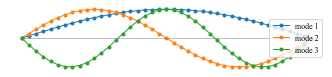

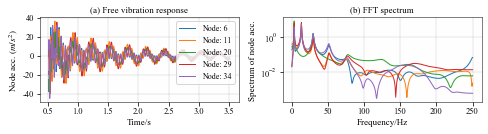

In [6]:
fig, ax = plt.subplots(figsize=(12/2.54, 3/2.54), tight_layout=True)
ax.plot(res0['mode'], marker='.')
ax.plot([0, 40], [0, 0], 'grey', alpha=0.5)
ax.axis('off')
ax.legend(['mode 1', 'mode 2', 'mode 3'], loc='right')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17.5/2.54, 5/2.54), tight_layout=True)
t_start = 0.51
t_end = 3.51
a = int(t_start*fs)
b = int(t_end*fs)
sig = res0['acc'][a:b, sensor_locs]
time = res0['time'][a:b]
n = len(time)
for j, s in enumerate(sensor_locs):
    ax1.plot(time, sig[:, j], label=f'Node: {s:1d}', lw=1)
ax1.grid('on')
ax1.legend(loc='upper right')
ax1.set_ylabel('Node acc. $(m/s^2)$')
ax1.set_xlabel('Time/s')
ax1.set_title('(a) Free vibration response')

for j, s in enumerate(sensor_locs):
    Yf = rfft(sig[:, j]) * 2 / n
    xf = rfftfreq(n, 1/fs)
    ax2.semilogy(xf, np.abs(Yf), label=f'node: {s:1d}')
ax2.grid('on')
ax2.set_ylabel('Spectrum of node acc.')
ax2.set_xlabel('Frequency/Hz')
ax2.set_title('(b) FFT spectrum')
plt.show()

Parameters identification by `ERA` and `FVRMD`

Results by `ERA`:
   Damping ratio   Error_d   Freqency  Error_f (%)
0       0.019962 -0.191459   3.321500    -0.032863
1       0.012475 -0.200164  13.257937    -0.243977
2       0.019743 -1.285192  29.551315    -1.176953
   MAC ERA-FEM
0     0.999997
1     0.999989
2     0.999568


(-2.0, 42.0, -1.1, 1.1)

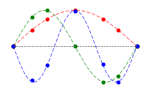

In [7]:
# ERA
K = 3
resE = ERA(data[:2000], nin=1, order=K, fs=fs)
print('Results by `ERA`:')
print(pd.DataFrame({
    "Damping ratio": resE['damp_r'],
    "Error_d": err_in_percent(res0['damp_r'][:K], resE['damp_r']),
    "Freqency": resE['freq'],
    "Error_f (%)": err_in_percent(res0['freq'][:K], resE['freq'])
}))

s_loc = np.concatenate(([0], sensor_locs, [40]))
x_loc = np.arange(41)

mode_t = res0['mode']/np.abs(res0['mode']).max(axis=0) # FEM mode
modeE = resE['mode']/np.abs(resE['mode']).max(axis=0)  # ERA mode
mask = np.sign(mode_t[sensor_locs, :])  # define a mask as the signs of mode
modeE = mask * np.abs(modeE)

# MAC
macE = [get_MAC(mode_t[sensor_locs, k], modeE[:, k]) for k in range(K)]
print(pd.DataFrame({
    'MAC ERA-FEM': macE
}))

# mode shape
modeE = np.concatenate((np.zeros((1, K)),
                       modeE,
                       np.zeros((1, K))), axis=0)

fig, ax = plt.subplots(figsize=(5/2.54, 3/2.54), layout="constrained")
lns = ax.plot(x_loc, mode_t, '--', lw=1, alpha=0.5)
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = plt.plot(s_loc, modeE, '.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax.plot(x_loc, np.zeros(x_loc.shape), '--', c='#454545', lw=0.5)
ax.axis('off')

In [8]:
# FVRMD
K = 3
ampF = np.zeros((num_sensor, K))
damp_rF = np.zeros((num_sensor, K))
freqF = np.zeros((num_sensor, K))
phaseF = np.zeros((num_sensor, K))
damp_rF_err = np.zeros((num_sensor, K))
freqF_err = np.zeros((num_sensor, K))
order = [[0, 1, 2],
         [0, 1, 2],
         [0, 2],
         [0, 1, 2],
         [0, 1, 2]]  # prior knowledge

for chn in tqdm(range(num_sensor)):
    K = len(order[chn])
    freq0 = 0.95*res0['freq'][order[chn]]
    damp_r0 = np.zeros(K)
    # a = np.array([1000, 500, 180])
    a = 1/freq0 * fs * 10
    n_seg = np.array(a, dtype=int)
    # print(n_seg)
    dataF = data[:3000, chn]
    resF, logF = FVRMD(dataF, fs, damp_r0, freq0, n_seg)

    ampF[chn, order[chn]] = resF['amp']
    damp_rF[chn, order[chn]] = resF['damp_r']
    damp_rF_err[chn, order[chn]] = err_in_percent(res0['damp_r'][order[chn]],
                                                resF['damp_r'])
    freqF[chn, order[chn]] = resF['freq']
    freqF_err[chn, order[chn]] = err_in_percent(res0['freq'][order[chn]],
                                                resF['freq'])
    phaseF[chn, order[chn]] = resF['phase']

100%|██████████| 5/5 [00:56<00:00, 11.26s/it]


Results by `FVRMD`:
   Damping ratio  Error_d  Freqency  Error_f (%)
0        0.02005     0.25    3.3211        -0.04
1        0.01249    -0.07   13.2568        -0.25
2        0.01998    -0.09   29.5109        -1.31
   MAC ERA-FEM
0     0.999996
1     0.999970
2     0.998859


(-2.0, 42.0, -1.1, 1.1)

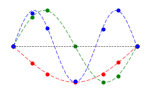

In [9]:
resF = params_assemble(ampF, damp_rF, freqF, phaseF, ref=0, method='max')

print('Results by `FVRMD`:')
vv = np.array(resF['damp_r'])
ww = np.array(resF['freq'])
print(pd.DataFrame({
    "Damping ratio": np.round(vv*1e5)/1e5,
    "Error_d": np.round(err_in_percent(res0['damp_r'][:K], resF['damp_r'])*1e2)/1e2,
    "Freqency": np.round(ww*1e4)/1e4,
    "Error_f (%)": np.round(err_in_percent(res0['freq'][:K], resF['freq'])*1e2)/1e2
}))

s_loc = np.concatenate(([0], sensor_locs, [40]))
x_loc = np.arange(41)

mode_t = res0['mode']/np.abs(res0['mode']).max(axis=0)  # FEM mode
mode_t[:, 0] = -mode_t[:, 0]
mode_t[:, 2] = -mode_t[:, 2]
modeE = resF['mode']/np.abs(resF['mode']).max(axis=0)  # ERA mode
mask = np.sign(mode_t[sensor_locs, :])  # define a mask as the signs of mode
modeE = mask * np.abs(modeE)

# MAC
macE = [get_MAC(mode_t[sensor_locs, k], modeE[:, k]) for k in range(K)]
print(pd.DataFrame({
    'MAC ERA-FEM': macE
}))

# mode shape
modeE = np.concatenate((np.zeros((1, K)),
                       modeE,
                       np.zeros((1, K))), axis=0)

fig, ax = plt.subplots(figsize=(5/2.54, 3/2.54), layout="constrained")
lns = ax.plot(x_loc, mode_t, '--', lw=1, alpha=0.5)
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = plt.plot(s_loc, modeE, '.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax.plot(x_loc, np.zeros(x_loc.shape), '--', c='#454545', lw=0.5)
ax.axis('off')

In [ ]:
print('Amplitude:')
print(pd.DataFrame(ampF))
print('Damping ratio:')
print(pd.DataFrame(damp_rF))
print(pd.DataFrame(damp_rF_err))
print('Frequency')
print(pd.DataFrame(freqF))
print(pd.DataFrame(freqF_err))
print('Phase')
print(pd.DataFrame(phaseF))

In [ ]:
# damp
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(12/2.54, 12/2.54), tight_layout=True)

lns = ax1.plot(logF['damp_r'], marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = ax1.plot(np.ones_like(logF['damp_r']) * res0['damp_r'], '--')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax1.set_title('varying damp ratio')

lns = ax2.plot((logF['alpha']), marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax2.set_title('varying alpha')

lns = ax3.plot(np.log10(logF['loss_reg']), '--', marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = ax3.plot(np.log10(logF['diff'][1:]), '-.', marker='<')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax3.set_title('varying loss_reg')
plt.show()